### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import warnings
import torch   
import torchvision  
from torch import nn                                

### **THE POKEMON DATASET:**
- The dataset is a collection of Pokemon sprites obtained from [**PokemonDB**](https://pokemondb.net/sprites). I will download, extract and load the dataset. 

In [3]:
#@ GETTING THE DATASET: 
d2l.DATA_HUB["pokemon"] = (d2l.DATA_URL + 'pokemon.zip', 
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')          # Path to Dataset.
data_dir = d2l.download_extract("pokemon")                                      # Downloading and Extracting the Dataset. 
pokemon = torchvision.datasets.ImageFolder(data_dir)                            # Initializing DataLoader. 

- I will resize each image into 64X64 and normalize the data with 0.5 mean and 0.5 standard deviation. 

In [4]:
#@ PREPARING THE DATASET: 
batch_size = 256                                              # Initialization. 
transformer = torchvision.transforms.Compose([                # Initializing Compose Instance. 
              torchvision.transforms.Resize((64, 64)),        # Resizing Images. 
              torchvision.transforms.ToTensor(),              # Converting into Tensors. 
              torchvision.transforms.Normalize(0.5, 0.5)])    # Normalizing the Data. 
pokemon.transform = transformer                               # Transforming the Pokemon Dataset. 
data_iter = torch.utils.data.DataLoader(
            pokemon, batch_size=batch_size, shuffle=True, 
            num_workers=2)                                    # Initializing Data Iterations. 

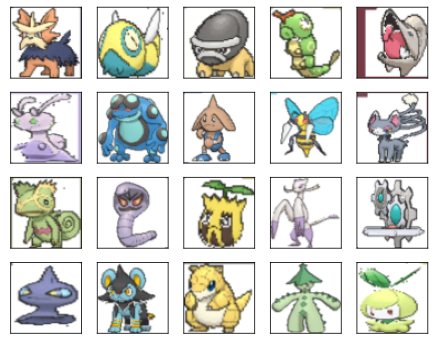

In [5]:
#@ VISUALIZING THE DATASET: 
warnings.filterwarnings("ignore")
d2l.set_figsize((5, 5))
for X, y in data_iter:
  imgs = X[0:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5       # Getting Images. 
  d2l.show_images(imgs, num_rows=4, num_cols=5)               # Visualizing Images. 
  break

### **THE GENERATOR:**
- The Generator needs to map the noise variable to a RGB image. I will use transposed convolutional layer to enlarge the input image. The basic block of Generator contains a transposed convolution layer followed by the batch normalization and RELU activation function. 

In [6]:
#@ DEFINING THE GENERATOR:
class G_Block(nn.Module):                                                       # Initializing Generator. 
  def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, 
               padding=1, **kwargs):                                            # Initializing Constructor Function. 
    super(G_Block, self).__init__(**kwargs)
    self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels, 
                                           kernel_size, strides, padding, 
                                           bias=False)                          # Initializing Transposed Convolution Layer. 
    self.batch_norm = nn.BatchNorm2d(out_channels)                              # Initializing Batch Normalization Layer. 
    self.activation = nn.ReLU()                                                 # Initializing RELU Activation Layer. 
  
  def forward(self, X):                                                         # Forward Propagation Layer. 
    return self.activation(self.batch_norm(self.conv2d_trans(X)))               # Implementation of Layers. 
#@ INSPECTING THE IMPLEMENTATION: 
X = torch.zeros((2, 3, 16, 16))                                                 # Initializing Tensor. 
G_block = G_Block(20)                                                           # Implementation. 
G_block(X).shape                                                                # Inspecting Shape. 

torch.Size([2, 20, 32, 32])

- The Generator consists of four blocks that increase height and width of input from 1 to 32. The transposed convolution layer is used to generate the output. The tanh activation function is used to project output values into the range of -1 and 1. 

In [7]:
#@ INITIALIZING THE GENERATOR: 
n_G = 64                                                                  # Initialization. 
net_G = nn.Sequential(G_Block(in_channels=100, out_channels=n_G*8, 
                              strides=1, padding=0),                      # Output: 64*8, 4, 4.
                      G_Block(in_channels=n_G*8, out_channels=n_G*4),     # Output: 64*4, 8, 8.
                      G_Block(in_channels=n_G*4, out_channels=n_G*2),     # Output: 64*2, 16, 16. 
                      G_Block(in_channels=n_G*2, out_channels=n_G),       # Output: 64, 32, 32.  
                      nn.ConvTranspose2d(in_channels=n_G,out_channels=3, 
                                         kernel_size=4, stride=2, 
                                         padding=1, bias=False),          # Implementation of Transposed Convolution. 
                      nn.Tanh())                                          # Implementation of Tanh Activation. 
#@ IMPLEMENTATION OF GENERATOR: 
X = torch.zeros((1, 100, 1, 1,))                                          # Initializing Tensor. 
net_G(X).shape                                                            # Inspecting Shape of Output. 

torch.Size([1, 3, 64, 64])

### **THE DISCRIMINATOR:**
- The Discriminator is a convolution layer followed by a batch normalization layer and Leaky RELU activation function. Leaky RELU is a nonlinear function that gives a non zero output for a negative input. It aims to fix the RELU problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of RELU is 0.

In [8]:
#@ DEFINING THE DISCRIMINATOR: 
class D_Block(nn.Module):                                                         # Initializing Discriminator. 
  def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, 
               padding=1, alpha=0.2, **kwargs):                                   # Initializing Constructor Function. 
    super(D_Block, self).__init__(**kwargs)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, 
                            strides, padding, bias=False)                         # Initializing Convolution Layer. 
    self.batch_norm = nn.BatchNorm2d(out_channels)                                # Initializing Batch Normalization Layer. 
    self.activation = nn.LeakyReLU(alpha, inplace=True)                           # Initializing Leaky RELU Activation. 
  
  def forward(self, X):                                                           # Initializing Forward Propagation. 
    return self.activation(self.batch_norm(self.conv2d(X)))                       # Implementation of Layers. 
#@ IMPLEMENTATION OF THE DISCRIMINATOR: 
X = torch.zeros((2, 3, 16, 16))                                                   # Initializing a Tensor. 
d_block = D_Block(20)                                                             # Initializing Discriminator. 
d_block(X).shape                                                                  # Implementation of Discriminator. 

torch.Size([2, 20, 8, 8])

In [9]:
#@ INITIALIZING THE DISCRIMINATOR: 
n_D = 64                                                             # Initialization. 
net_D = nn.Sequential(D_Block(n_D),                                  # Output: 64, 32, 32.
                      D_Block(in_channels=n_D, out_channels=n_D*2),  # Output: 64*2, 16, 16.
                      D_Block(in_channels=n_D*2,out_channels=n_D*4), # Output: 64*4, 8, 8.
                      D_Block(in_channels=n_D*4,out_channels=n_D*8), # Output: 64*8, 4, 4.
                      nn.Conv2d(in_channels=n_D*8, out_channels=1, 
                                kernel_size=4, bias=False))          # Implementation of Convolution Layer. 
#@ IMPLEMENTATION: 
X = torch.zeros((1, 3, 64, 64))                                      # Initializing Tensor. 
net_D(X).shape                                                       # Inspecting the Shape. 

torch.Size([1, 1, 1, 1])

### **TRAINING:**
- I will be using the same learning rate for both generator and discriminator since the networks are similar to each other. I will change  β1  in Adam from  0.9  to  0.5. It decreases the smoothness of the momentum which is the exponentially weighted moving average of past gradients to take care of the rapid changing gradients because the generator and the discriminator fight with each other. The random generated noise Z is a 4D tensor. 

In [12]:
#@ TRAINING THE MODEL:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, 
          device=d2l.try_gpu()):                                       # Function for Training. 
  loss = nn.BCEWithLogitsLoss(reduction="sum")                         # Initializing Cross Entropy Loss Function. 
  for w in net_D.parameters():                                         # Discriminator. 
    nn.init.normal_(w, 0, 0.02)                                        # Normal Initialization. 
  for w in net_G.parameters():                                         # Generator. 
    nn.init.normal_(w, 0, 0.02)                                        # Normal Initialization. 
  net_D, net_G = net_D.to(device), net_G.to(device)                    # Enabling GPU.  
  trainer_hp = {"lr": lr, "betas": [0.5, 0.999]}                       # Initializing Optimization Parameters. 
  trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)       # Adam Optimizer for Discriminator.  
  trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)       # Adam Optimizer for Generator. 
  animator = d2l.Animator(xlabel="epoch", ylabel="loss", 
                          xlim=[1, num_epochs],nrows=2,figsize=(5, 5), 
                          legend=["discriminator", "generator"])       # Initializing Animator. 
  animator.fig.subplots_adjust(hspace=0.3)                             # Initializing Subplots. 
  for epoch in range(1, num_epochs + 1):
    timer = d2l.Timer()                                                # Initializing Timer. 
    metric = d2l.Accumulator(3)                                        # Initializing Accumulator. 
    for X, _ in data_iter: 
      batch_size = X.shape[0]                                          # Initializing Batch Size. 
      Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))      # Initializing Tensor. 
      X, Z = X.to(device), Z.to(device)                                # Enabling GPU. 
      metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),    # Updating Discriminator. 
                 d2l.update_G(Z, net_D, net_G, loss, trainer_G),       # Updating Generator. 
                 batch_size)                                           # Acccumulating Updates. 
    Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device) # Initializing Tensor. 
    fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5                    # Normalizing Synthetic Data. 
    imgs = torch.cat([torch.cat([fake_x[i*7 + j].cpu().detach() \
                                 for j in range(7)], dim=1) \
                      for i in range(len(fake_x) // 7)], dim=0)
    animator.axes[1].cla()
    animator.axes[1].imshow(imgs)
    loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]      # Getting Discriminator and Generator Loss. 
    animator.add(epoch, (loss_D, loss_G))
  print(f"loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, "
        f"{metric[2]/timer.stop():.1f} examples/sec on {str(device)}")

loss_D 0.134, loss_G 8.398, 538.7 examples/sec on cuda:0


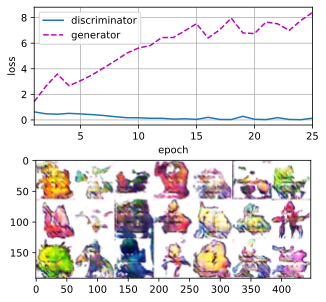

In [13]:
#@ TRAINING THE MODEL: 
latent_dim, lr, num_epochs = 100, 0.005, 25                            # Initializing Parameters. 
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)             # Training the Model. 